# HKUST, ECE, FANLAB, Unitree Robot Dog project
## Author: Jonathan Chan

In [1]:
import socket
import time
import json
import numpy as np
from IPython.display import clear_output
#HOST = '192.168.123.162'# my own address, need to update in c++
#PORT = 4141 #Dummy, init used
class unitreeController():
    def __init__(self, host, port):
        self.host = host
        self.port = port
        self.addr = (self.host, self.port)
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        self.sock.bind((self.host, self.port))
        self.sock.settimeout(5)
        self.imu = 0 # It will be a json packet
        self.rawData = " "
        self.cmd = {}
        self.cmd['mode'] = 1
        self.cmd['forwardSpeed'] = 0.0
        self.cmd['sideSpeed'] = 0.0
        self.cmd['rotateSpeed'] = 0.0
        #Disabled in c++ side
        self.cmd['bodyHeight'] = 0.0
        self.cmd['roll'] = 0.0
        self.cmd['pitch'] = 0.0
        self.cmd['yaw'] = 0.0
        #self.cmd = json.dumps(self.cmd)
    def __del__(self):
        self.sock.close()
    def getState(self): #Get IMU data
        self.rawData, self.addr = self.sock.recvfrom(1024)
        #print(self.rawData)
        self.imu = json.loads(self.rawData.decode())
        #print(self.imu)
    def setCmd(self): #Run to send command to unitree
        cmdMsg = "{mode},{forwardSpeed},{sideSpeed},{rotateSpeed},{bodyHeight},{roll},{pitch},{yaw}"\
        .format(mode=int(self.cmd['mode']),forwardSpeed=self.cmd['forwardSpeed'],sideSpeed=self.cmd['sideSpeed'],rotateSpeed=self.cmd['rotateSpeed'],bodyHeight=self.cmd['bodyHeight'],roll=self.cmd['roll'],pitch=self.cmd['pitch'],yaw=self.cmd['yaw'])
        self.sock.sendto(cmdMsg.encode(), self.addr)

class rawPath():
    def __init__(self):
        self.loc_x=[] #local
        self.loc_y=[]
        self.loc_yaw=[]
        self.glo_x=[] #global
        self.glo_y=[]
        self.glo_yaw=[]
        
        self.err_x=[]
        self.err_y=[]
        self.err_yaw=[]
        
        self.t=[]
    def record(self, x, y, yaw, t=0):
        self.loc_x.append(x)
        self.loc_y.append(y)
        self.loc_yaw.append(yaw)
        self.t.append(t)
    def recordErr(self, x, y, yaw, t=0):
        self.err_x.append(x)
        self.err_y.append(y)
        self.err_yaw.append(yaw)

class setPoint:
     def __init__(self, x=0, y=0, yaw=0, toleranceCm=0.1, stopMs=0):
            self.x=x #Local frame
            self.y=y #local frame
            self.yaw=yaw #Global frame
            self.toleCm = toleranceCm #tolerance cm 
            self.stopMs = stopMs #10ms resolution
def speedLim(x, lim):
    return np.sign(x)*np.min([np.abs(x), lim])

In [ ]:
del myUt
myUt = None

In [ ]:
myUt = unitreeController('192.168.123.162', 3114)
for i in range(50):
    myUt.getState()
    #print(myUt.imu['pos'])
    myUt.cmd['mode']=2
    myUt.cmd['forwardSpeed']=-0.5
    myUt.setCmd()
    time.sleep(0.01)
for i in range(50):
    myUt.getState()
    #print(myUt.imu)
    myUt.cmd['mode']=2
    myUt.cmd['forwardSpeed']=0.1
    myUt.setCmd()
    time.sleep(0.01)

del myUt

In [34]:
myUt = unitreeController('192.168.123.162', 3114)
myRawPath = rawPath()
mySp = setPoint(-0.,0.1,-0.0*np.pi); #-0.9*np.pi

for i in range(200):
    myUt.getState()
    #myUt.imu['rpy'][2] = myUt.imu['rpy'][2]+np.pi #0~2pi
    myRawPath.record(myUt.imu['pos'][0], myUt.imu['pos'][1], myUt.imu['rpy'][2])
    
    ctrl_fs = 2*(mySp.x-myUt.imu['pos'][0])
    ctrl_ss = 3*(mySp.y-myUt.imu['pos'][1]) # + is left, #- is right
    ctrl_rs = 0  # + is anti clk, #- is clk, 
    yaw_err = (mySp.yaw-myUt.imu['rpy'][2]) #Rad
    ctrl_rs = 2*(yaw_err) 
    if np.abs(yaw_err)>np.pi:
        ctrl_rs = -(ctrl_rs)#+3.9*np.pi
    myRawPath.recordErr(0,0,ctrl_rs)
    myUt.cmd['mode']=2
    myUt.cmd['forwardSpeed'] = speedLim(ctrl_fs, 0.9) 
    myUt.cmd['sideSpeed']    = speedLim(ctrl_ss, 0.8) 
    myUt.cmd['rotateSpeed']  = speedLim(ctrl_rs, 0.8) 
    myUt.setCmd()
    time.sleep(0.01)
    clear_output(wait=True)
    
for i in range(5): #Stop command
    myRawPath.record(myUt.imu['pos'][0], myUt.imu['pos'][1], myUt.imu['rpy'][2])
    myUt.cmd['mode'] = 1
    myUt.cmd['forwardSpeed'] = 0
    myUt.cmd['sideSpeed'] = 0
    myUt.setCmd()
    time.sleep(0.01)
myRawPath.glo_x = myRawPath.loc_x*np.cos(myRawPath.loc_yaw)+myRawPath.loc_y*np.sin(myRawPath.loc_yaw)
myRawPath.glo_y = myRawPath.loc_x*np.sin(myRawPath.loc_yaw)+myRawPath.loc_y*np.cos(myRawPath.loc_yaw)
del myUt

NameError: name 'myRawPath' is not defined

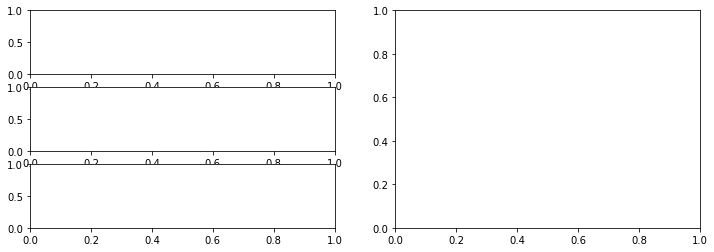

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

plt.close('all')
fig = plt.figure(figsize=(12,4)) #constrained_layout=True
gs = fig.add_gridspec(3, 2)
ax=[]
ax.append(fig.add_subplot(gs[0, 0]))
ax.append(fig.add_subplot(gs[1, 0]))
ax.append(fig.add_subplot(gs[2, 0]))
ax.append(fig.add_subplot(gs[:, 1]))
thisAx = ax[0]
thisAx.plot(myRawPath.loc_x)
thisAx.set_ylabel('x (m)')
thisAx = ax[1]
thisAx.plot(myRawPath.loc_y)
thisAx.set_ylabel('y (m)')
thisAx = ax[2]
#thisAx.plot(np.divide(myRawPath.loc_yaw,np.pi))
thisAx.plot(np.divide(myRawPath.err_yaw,1))
thisAx.set_ylabel('Yaw (pi rad)')
thisAx = ax[3]
thisAx.plot(myRawPath.glo_x,myRawPath.glo_y)
thisAx.plot(myRawPath.glo_x[-1],myRawPath.glo_y[-1], 'rx')
thisAx.text(myRawPath.glo_x[-1],myRawPath.glo_y[-1], '  end')
thisAx.plot(myRawPath.glo_x[ 0],myRawPath.glo_y[ 0], 'ro')
thisAx.text(myRawPath.glo_x[ 0],myRawPath.glo_y[ 0], '  start')
thisAx.set_title("Calculated Position/odometry")
thisAx.set_xlabel('x (m)')
thisAx.set_ylabel('y (m)')
thisAx.set_aspect(1)
xlim=5
ylim=5
thisAx.set_xlim([-xlim,xlim])
thisAx.set_ylim([-ylim,ylim])

#fig.savefig("setpoint_xy7.png")

In [ ]:
myUt = unitreeController('192.168.123.162', 3114)
myUt.getState()
print(myUt.imu['pos'])
del myUt

# PID - path

In [ ]:
# + is left, #- is right
# + is anti clk, #- is clk, 
    

In [35]:
myUt = unitreeController('192.168.123.162', 3114)
myRawPath = rawPath()
spLst = []
box_y = 3.25
box_x = 0.8
box_a = -0.01*np.pi
waitTime = 1000
spLst.append(setPoint( 3.1,     0.0,box_a, 0.05, 500))
spLst.append(setPoint( box_y,     0.0,box_a, 0.05, waitTime))

# spLst.append(setPoint( -box_y,     0.0,box_a, 0.05))
spLst.append(setPoint( box_y,  -box_x,box_a, 0.05, waitTime)) #Src 1
spLst.append(setPoint( box_y,-2*box_x,box_a, 0.05, waitTime)) #Src 2
# spLst.append(setPoint( box_y,     0.0,box_a, 0.05, 1000)) #Src 3
spLst.append(setPoint( box_y,   box_x-0.3,box_a, 0.05, waitTime)) #Src 4
spLst.append(setPoint( box_y, 2*box_x-0.4,box_a, 0.05, waitTime)) #Src 5
spLst.append(setPoint(   0.0, 0.0,0,0.05)) 
arrivedCnt = 0
def move2Sp(mySp):
    for i in range(10000):
        myUt.getState()
        errX, errY, errYaw = mySp.x-myUt.imu['pos'][0], mySp.y-myUt.imu['pos'][1], mySp.yaw-myUt.imu['rpy'][2]
        if -mySp.toleCm<errX<mySp.toleCm and -mySp.toleCm<errY<mySp.toleCm:
            arrivedCnt=arrivedCnt+1
        else:
            arrivedCnt=0  
        if arrivedCnt> 20:
            if mySp.stopMs<=0:
                print(arrivedCnt)
                break
            else :
                mySp.stopMs=mySp.stopMs-10
                print(mySp.stopMs)
        ctrl_fs,ctrl_ss,ctrl_rs = 2*(errX),2.5*(errY),1.5*(errYaw)
        if np.abs(errYaw)>np.pi:
            ctrl_rs = -(ctrl_rs)#+3.9*np.pi
        myRawPath.record(myUt.imu['pos'][0], myUt.imu['pos'][1], myUt.imu['rpy'][2])
        myRawPath.recordErr(errX,errY,errYaw)
        myUt.cmd['mode']=2
        myUt.cmd['forwardSpeed'], myUt.cmd['sideSpeed'] ,myUt.cmd['rotateSpeed'] = speedLim(ctrl_fs, 0.7),speedLim(ctrl_ss, 0.5),speedLim(ctrl_rs, 0.7) 
        myUt.setCmd()
        time.sleep(0.01)
        clear_output(wait=True)
for sp in spLst:
    move2Sp(sp)

for i in range(5): #Stop command
    myRawPath.record(myUt.imu['pos'][0], myUt.imu['pos'][1], myUt.imu['rpy'][2])
    myUt.cmd['mode'] = 1
    myUt.cmd['forwardSpeed'],myUt.cmd['sideSpeed'] = 0,0
    myUt.setCmd()
    time.sleep(0.01)
myRawPath.glo_x = myRawPath.loc_x*np.cos(myRawPath.loc_yaw)+myRawPath.loc_y*np.sin(myRawPath.loc_yaw)
myRawPath.glo_y = myRawPath.loc_x*np.sin(myRawPath.loc_yaw)+myRawPath.loc_y*np.cos(myRawPath.loc_yaw)
del myUt

In [ ]:
np.savez("01", myRawPath)

## Vision PID

In [2]:
import cv2 as cv
from scipy.signal import find_peaks
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np

In [3]:
cam = cv.VideoCapture('http://192.168.123.12:8080/?action=stream')
h, w = 480, 848 #img.shape

h_half, w_half = int(h/2), int(w/2)
upLim, lwLim = h_half+50, h_half+100
last_l_pos, last_r_pos = 0, w
centerPt = w_half


plt.close('all')

def runCv(isPlot=0):
    global last_l_pos, last_r_pos
    ret, img = cam.read()
    l_pos, r_pos = [],[]
    ddmean = 0
    for j in range(3): #rgb
        meanVec = []
        for i in range(upLim,lwLim, 3):
            meanVec.append(img[i,:, j])
        ddmean = np.diff(np.mean(meanVec, axis=0)) #dy/dx
        #ddmean = np.convolve(meanVec,[-1,0,1])
        ddmean = np.abs(np.convolve(ddmean,(1/9)*np.ones(9))) #mean+abs filter
        peaks, _ = find_peaks(ddmean[0:int(centerPt)], prominence=1,width=5) #left image
        peaks2, _ = find_peaks(ddmean[centerPt:-1], prominence=1,width=5) #Right image 
        if len(peaks)>0:
            l_pos.append(peaks[-1])
        if len(peaks2)>0:
            r_pos.append(peaks2[0])
    cen = 0
    if len(l_pos)>0:
        cen = 0.2*last_l_pos+0.8*np.mean(l_pos, dtype=int) #complementary fiter, weighted mean
        cen = int(cen)
    else:
        cen = 0
    cv.line(img, (cen,0),(cen,w), (0,0,255), 3)
    last_l_pos=cen
    if len(r_pos)>0:
        cen = 0.2*last_r_pos+0.8*(w_half+np.mean(r_pos, dtype=int))#peaks2[0]#w_half+int((peaks2[0]+peaks2[1])/2)
        cen = int(cen)
    else:
        cen = w
    cv.line(img, (cen,0),(cen,w), (0,255,0), 3)
    last_r_pos=cen
    rbtCenter=int((last_r_pos+last_l_pos)/2)
    lineDistance=0
    centerErr = rbtCenter-centerPt
    if len(peaks)>0 and len(peaks2)>0:
        lineDistance = (last_r_pos-last_l_pos)
    if isPlot:
        cv.line(img, (rbtCenter,0),(rbtCenter,w), (255,255,0), 2) #middle line
        cv.line(img, (centerPt,0),(centerPt,w), (255,0,0), 1) #middle line
        cv.line(img, (0,upLim),(w,upLim), (255,0,0), 1) #middle line
        cv.line(img, (0,lwLim),(w,lwLim), (255,0,0), 1) #middle line
        cv.putText(img, str(centerErr)+',  '+str(lineDistance), (h,h-10), cv.FONT_HERSHEY_SIMPLEX, 1, (255,0,0),2,cv.LINE_AA)
        cv.imshow('D435 image', img)
    
    return centerErr, lineDistance

In [4]:
myUt = unitreeController('192.168.123.162', 3114)
myRawPath = rawPath()
spLst = []
box_y = 3.25
box_x = 0.8
box_a = -0.01*np.pi
waitTime = 1000
spLst.append(setPoint( 0.0,     0.0,0.0, 0.05, 500))

arrivedCnt = 0
def move2Sp(mySp):
    global arrivedCnt
    for i in range(10000):
        runCv(True)
        myUt.getState()
        errX, errY, errYaw = mySp.x-myUt.imu['pos'][0], mySp.y-myUt.imu['pos'][1], mySp.yaw-myUt.imu['rpy'][2]
        if -mySp.toleCm<errX<mySp.toleCm and -mySp.toleCm<errY<mySp.toleCm:
            arrivedCnt=arrivedCnt+1
        else:
            arrivedCnt=0  
        if arrivedCnt> 20:
            if mySp.stopMs<=0:
                print(arrivedCnt)
                break
            else :
                mySp.stopMs=mySp.stopMs-10
                print(mySp.stopMs)
        ctrl_fs,ctrl_ss,ctrl_rs = 2*(errX),2.5*(errY),1.5*(errYaw)
        if np.abs(errYaw)>np.pi:
            ctrl_rs = -(ctrl_rs)#+3.9*np.pi
        myRawPath.record(myUt.imu['pos'][0], myUt.imu['pos'][1], myUt.imu['rpy'][2])
        myRawPath.recordErr(errX,errY,errYaw)
        myUt.cmd['mode']=2
        myUt.cmd['forwardSpeed'], myUt.cmd['sideSpeed'] ,myUt.cmd['rotateSpeed'] = speedLim(ctrl_fs, 0.7),speedLim(ctrl_ss, 0.5),speedLim(ctrl_rs, 0.7) 
        myUt.setCmd()
        
        time.sleep(0.01)
        clear_output(wait=True)

for sp in spLst:
    move2Sp(sp)

for i in range(5): #Stop command
    myRawPath.record(myUt.imu['pos'][0], myUt.imu['pos'][1], myUt.imu['rpy'][2])
    myUt.cmd['mode'] = 1
    myUt.cmd['forwardSpeed'],myUt.cmd['sideSpeed'] = 0,0
    myUt.setCmd()
    time.sleep(0.01)

myRawPath.glo_x = myRawPath.loc_x*np.cos(myRawPath.loc_yaw)+myRawPath.loc_y*np.sin(myRawPath.loc_yaw)
myRawPath.glo_y = myRawPath.loc_x*np.sin(myRawPath.loc_yaw)+myRawPath.loc_y*np.cos(myRawPath.loc_yaw)
del myUt
cv.destroyAllWindows()

timeout: timed out

# Mini-jerk

In [ ]:
import numpy as np
from scipy.linalg import solve
import matplotlib.pyplot as plt
#matplotlib widget

class cptKp1d: #cubic polynomial trajectory
    def __init__(self,t0,tf,q0,v0,qf,vf):
        self.t0=t0
        self.tf=tf
        self.q0=q0
        self.v0=v0
        self.qf=qf
        self.vf=vf
        # Ax=b
        self.A = np.array([[1, t0, t0**2, t0**3], [0, 1, 2*t0, 3*t0**2],[1, tf, tf**2, tf**3], [0, 1, 2*tf, 3*tf**2]])
        self.b = np.array([q0,v0,qf,vf])
        self.x = solve(self.A, self.b)
    q  = lambda self,t : self.x[0]+self.x[1]*t+self.x[2]*t**2+self.x[3]*t**3
    qd = lambda self,t : self.x[1]+2*self.x[2]*t+3*self.x[3]*t**2
    qdd= lambda self,t : 2*self.x[2]*t+6*self.x[3]*t
    
    
    

In [ ]:
# control path generation
kp_x = [2.0, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 2.0]
kp_y = [0.0, 1.0, 0.8, 1.0, 0.8, 1.0, 0.8, 1.0, 0.8, 1.0, 0.0]
pd = 0.5
kpd_x= [0.0, 0.0,  pd, 0.0,  pd, 0.0,  pd, 0.0,  pd, 0.0, 0.0] #start speed
kpd_y= [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] #start speed
dt = 1.0
kp_t = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0] #dT

kp_t = [0.0, 5.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 6.0] #dT
kp_t_nn=[]
for i in range(len(kp_t)):
    kp_t_nn.append(np.sum((kp_t[:i+1])))
kp_t=kp_t_nn.copy()


gasSrc_x = [0.0, 1.0, 2.0, 3.0, 4.0] 
gasSrc_y = [1.2, 1.2, 1.2, 1.2, 1.2] 
#t0,tf,q0,v0,qf,vf
planning = []
for i in range(len(kp_x)-1):
    planning.append([cptKp1d(kp_t[i],kp_t[i+1],kp_x[i],kpd_x[i],kp_x[i+1],kpd_x[i+1]), cptKp1d(kp_t[i],kp_t[i+1],kp_y[i],kpd_y[i],kp_y[i+1],kpd_y[i+1])])
limd_x = 0.5
limd_y = 0.9

In [ ]:
del myUt

In [ ]:
import numpy as np
myUt = unitreeController('192.168.123.162', 3114)


for plan in planning:
    tvec = np.linspace(plan[0].t0,plan[0].tf,100)
    vx=plan[0].qd(tvec)
    vy=plan[1].qd(tvec)
    for n in range(len(tvec)):
        myUt.getState()
        myUt.cmd['mode']=2
        vx[n]
        vy[n]
        myUt.cmd['mode']=2
        myUt.cmd['forwardSpeed'] = -vy[n]
        myUt.cmd['sideSpeed'] = -vx[n]
        myUt.setCmd()
    time.sleep(0.1)
del myUt

In [ ]:
tt = np.array([1,2,3])
for i in range(len(tt)):
    print(i)

## Achieved Code

In [ ]:
# UDP RX
sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
sock.bind((HOST, PORT))
sock.settimeout(5)
for i in range(50):
    data, addr = sock.recvfrom(1024)
    cmdMsg = "{mode},{forwardSpeed},{sideSpeed},{rotateSpeed},{bodyHeight},{roll},{pitch},{yaw}"\
    .format(mode=2,forwardSpeed=0.0,sideSpeed=0.,rotateSpeed=(i)/100,bodyHeight=0.5,roll=0,pitch=0,yaw=0)
    udpMsg = cmdMsg#"python send udp2\n"
    #sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # UDP

    n = sock.sendto(udpMsg.encode(), addr)
    time.sleep(0.05)
for i in range(50):
    data, addr = sock.recvfrom(1024)
    cmdMsg = "{mode},{forwardSpeed},{sideSpeed},{rotateSpeed},{bodyHeight},{roll},{pitch},{yaw}"\
    .format(mode=2,forwardSpeed=0.0,sideSpeed=0.,rotateSpeed=(100-i)/100,bodyHeight=0.5,roll=0,pitch=0,yaw=0)
    udpMsg = cmdMsg#"python send udp2\n"
    #sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # UDP

    n = sock.sendto(udpMsg.encode(), addr)
    time.sleep(0.05)
    
for i in range(10):
    data, addr = sock.recvfrom(1024)
    cmdMsg = "{mode},{forwardSpeed},{sideSpeed},{rotateSpeed},{bodyHeight},{roll},{pitch},{yaw}"\
    .format(mode=1,forwardSpeed=0.0,sideSpeed=0.,rotateSpeed=0,bodyHeight=0.5,roll=0,pitch=0,yaw=0)
    udpMsg = cmdMsg#"python send udp2\n"
    #sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # UDP

    n = sock.sendto(udpMsg.encode(), addr)
    time.sleep(0.05)
sock.close()
print(n,addr, data)